## CLASS IMPLEMENTATIONS

In [1]:
'''
RUN ONLY ONCE OTHERWISE MULTIPLE LOGGER HANDLERS WILL BE ADDED
'''
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.')
logger.handlers

2016-11-16 10:39:38,519 - root - INFO - Logger works.


In [152]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.spatial.distance import euclidean
import time
import cPickle

In [214]:
def get_cfg(cfg_path_or_dict):
    if type(cfg_path_or_dict) == dict:
        return cfg_path_or_dict
    if not os.path.isfile(cfg_path_or_dict):
        raise ValueError('Config must be path to valid .yml file or dict.')
    with open(cfg_path_or_dict, 'rb') as f:
        cfg = yaml.load(f)
    return cfg

def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f) 

In [51]:
class CaffeVectorsIterator(object):
    def __init__(self, file_path):
        log_pfx(self,'Reading Caffe Vector file %s...',file_path)
        self.f = open(file_path, 'rb')

    def next(self):
        try:
            # (id: int, vector: np array of float32)
            lineA = self.f.next()
            lineB = self.f.next()
            return (int(lineA.split(' ')[2]),  np.fromstring(lineB, dtype='f', sep=' '))
        except StopIteration:
            self.f.close()
            raise StopIteration

    def __del__(self):
        if self.f:
            self.f.close()


class CaffeVectorsIterable(object):
    def __init__(self, file_path):
        self.file_path = file_path

    def __iter__(self):
        return CaffeVectorsIterator(self.file_path)

In [365]:
class MultiHyperplanePartitioner(object):

    def __init__(self, cfg):
        if cfg:
            cfg = get_cfg(cfg)
            all_pivots=self.read_pivots(cfg)
            self.pivots, self.balance_score=self.select_top_k_pivots(all_pivots, int(cfg['base_sketch_length']))
            self.pivots=list(self.pivots)
            self.balance_score=list(self.balance_score)
            
    def save_self(self, file_path):
        MultiHyperplanePartitioner.save(self,file_path)
    
    @staticmethod
    def save(partitioner, file_path):
        log_pfx(None,'Persisting MultiHyperplanePartitioner to %s...',file_path)
        to_save=partitioner.pivots, partitioner.balance_score
        save_to(to_save, file_path)
        log_pfx(None,'Done...')
    
    
    @staticmethod
    def load(file_path, limit_pivots=None):
        if limit_pivots is not None:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s, limiting pivots count to %s...', file_path, limit_pivots )
        else:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s...',file_path)

        instance=MultiHyperplanePartitioner(None)
        tupl=load_from(file_path)
        if limit_pivots is None:
            instance.pivots=tupl[0]
            instance.balance_score=tupl[1]
        else:
            instance.pivots=tupl[0][:limit_pivots]
            instance.balance_score=tupl[1][:limit_pivots]
        instance.pivots=list(instance.pivots)
        instance.balance_score=list(instance.balance_score)
        return instance

    def select_top_k_pivots(self, all_pivots,k):
        log_pfx(self,'Selecting top %s pivots...',k)
        counters=[0]*len(all_pivots)
        n_obj=0
        t_start=time.time()
        for obj in CaffeVectorsIterable(cfg['dataset_path']):
            n_obj+=1
            if n_obj%10000==0:
                t_dur=time.time()-t_start
                t_start=time.time()
                log_pfx(self,'Adding counts for partitioning balance counter for dataset obj no. %s. Processing last 10000 objects took %ss...',n_obj,t_dur)
            for i, pivot_couple in enumerate(all_pivots):
                if self.get_partition(pivot_couple, obj)==1:
                    counters[i]+=1

        log_pfx(self,'Computing balance ratios and selecting top %s pivots...', k)
        balance_ratios=[abs(0.5-(float(count_1)/n_obj)) for i, count_1 in enumerate(counters)]
        sorted_pivots_with_ratings=sorted(zip(all_pivots, balance_ratios), key=lambda x: x[1])
        top_pivots, top_balance_score=zip(*[(tupl[0], tupl[1]) for tupl in sorted_pivots_with_ratings[:k]])
        return top_pivots, top_balance_score     

    def read_pivots(self, cfg):
        log_pfx(self,'Reading pivot file...')
        pivots = list()
        iterator = CaffeVectorsIterable(cfg['pivots_file_path']).__iter__()
        while True:
            try:
                pivot_A = iterator.next()
                pivot_B = iterator.next()
                pivots.append((pivot_A, pivot_B))
            except StopIteration:
                break
        return pivots

    def remove_pivot_couple(self, idx):
        self.pivots.pop(idx)
        self.balance_score.pop(idx)

    def get_partition(self, pivot_couple, obj):
        distance_A = euclidean(obj[1], pivot_couple[0][1]) # pairwise returns matrix
        distance_B = euclidean(obj[1], pivot_couple[1][1])
        if distance_A > distance_B:
            return 0
        else:
            return 1

    def get_partitions(self, obj):
        return [self.get_partition(pivot_couple, obj) for pivot_couple in self.pivots]

In [366]:
class SketchProducer(object):
    def __init__(self, cfg, partitioner=None):
        if cfg:
            self.cfg=get_cfg(cfg)
            if partitioner is None:
                self.partitioner=MultiHyperplanePartitioner(cfg)
            else:
                self.partitioner=partitioner
            log_pfx(self,'Transforming dataset to Sketch matrix...')
            sketch_matrix=np.matrix([self.partitioner.get_partitions(data_record) for data_record in CaffeVectorsIterable(cfg['dataset_path'])])
            log_pfx(self,'Sketch Matrix constructed with shape %s...',sketch_matrix.shape)
            log_pfx(self,'Optimizing sketch length to %s...', int(cfg['desired_sketch_length']))
            self.optimization_corrs=self.optimize_bit_length(sketch_matrix, int(cfg['desired_sketch_length']))
            
    def remove_one_bit(self, sketch_matrix): #removes single bit that will result in best improvement of mean correlation 
        bool_mask=[True]*sketch_matrix.shape[1]
        best_corr=1000
        best_idx=-1
        for i in xrange(len(bool_mask)):
            if i>0:
                bool_mask[i]=False
                bool_mask[i-1]=True
            else:
                bool_mask[i]=False
            mean_corr=SketchProducer.mean_couple_correlation(sketch_matrix[:, bool_mask])
            if mean_corr<best_corr:
                best_corr=mean_corr
                best_idx=i
        bool_mask[len(bool_mask)-1]=True
        bool_mask[best_idx]=False
        sketch_matrix=sketch_matrix[:, bool_mask]
        self.partitioner.remove_pivot_couple(best_idx)
        return sketch_matrix, best_corr
        
    def optimize_bit_length(self, sketch_matrix, desired_sketch_len):
        log_pfx(self, 'Initiating bit removal...')
        corr_vals=list()
        corr_vals.append(SketchProducer.mean_couple_correlation(sketch_matrix))
        bits_removed=0
        t_start=time.time()
        while sketch_matrix.shape[1]>desired_sketch_len:
            print(sketch_matrix.shape[1])
            if bits_removed>0 and bits_removed%5==0:
                t_dur=time.time()-t_start
                t_start=time.time()
                log_pfx(self, 'Removed %s bits. Removing last 5 bits took %ss...', bits_removed, t_dur)
            sketch_matrix, new_corr=self.remove_one_bit(sketch_matrix)
            corr_vals.append(new_corr)
            bits_removed+=1
        return corr_vals

    @staticmethod
    def mean_couple_correlation(sketch_matrix):
        corr_mtx = np.corrcoef(sketch_matrix.T) #matrix of correlations of columns of sketch matrix
        corr_vals=corr_mtx[np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)] #list of upper triangle of corr matrix (without diagonal)
        return np.mean(np.absolute(corr_vals)) #mean of absolute value of Pearson correlation coefficients 
    
        

## EXPERIMENTS

### Hyperplane partitioning

In [360]:
cfg={
    'pivots_file_path':'/home/kvassay/data/sketch-testing/pivots-random-2560.data',
    'base_sketch_length':1280,
    'dataset_path':'/home/kvassay/data/sketch-testing/profi-neuralnet-100K.data',
    'desired_sketch_length': 1280
}
t_start=time.time()
partitioner=MultiHyperplanePartitioner(cfg)
dur_s=time.time()-t_start
log_pfx(None,'Balanced pivot selection duration: %s', dur_s)

2016-11-16 16:39:42,868 - root - INFO - MultiHyperplanePartitioner| Reading pivot file...
2016-11-16 16:39:42,869 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/pivots-random-2560.data...
2016-11-16 16:39:45,269 - root - INFO - MultiHyperplanePartitioner| Selecting top 1280 pivots...
2016-11-16 16:39:45,270 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...


KeyboardInterrupt: 

Peristing partitioner...

In [218]:
PARTITIONER_SAVE_PATH='/home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model'
MultiHyperplanePartitioner.save(partitioner, PARTITIONER_SAVE_PATH)

2016-11-16 14:17:32,988 - root - INFO - NoneType| Persisting MultiHyperplanePartitioner to /home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model...
2016-11-16 14:17:36,869 - root - INFO - NoneType| Done...


#### How balanced is Hyperplane partitioning with pivot couples (ordered by balance deviation)
We randomly selected over 1200 random pivot couples and ordered them according to how balanced is the data set if we partition it with Hyperplane partitioning using these couples. Balance deviation is from 0 to 0.5, 0 being perfectly balanced, 0.5 resulting in only one partition containing all dataset objects. Deviation 0.1 means, that 40% of data set is in one partition and 60% in the other. We consider this acceptable state => it's ok to use first 128 pivots.

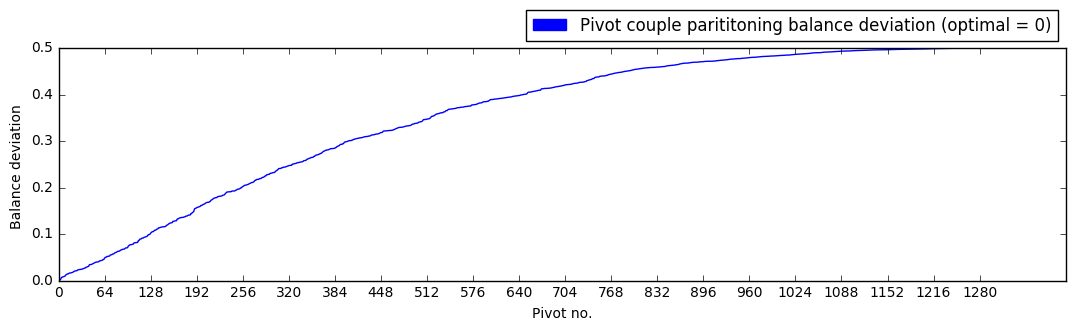

In [361]:
plt.figure(figsize=(13,3))
line=plt.plot(partitioner.balance_score, color='blue')
legend = mpatches.Patch(color='blue', label='Pivot couple parititoning balance deviation (optimal = 0)')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Pivot no.')
plt.ylabel('Balance deviation ')

plt.xticks(range(0, len(partitioner.balance_score)+1,64))
plt.show()

### Sketch matrix generation

In [367]:
cfg={
    'pivots_file_path':'/home/kvassay/data/sketch-testing/pivots-random-2560.data',
    'base_sketch_length':128,
    'dataset_path':'/home/kvassay/data/sketch-testing/profi-neuralnet-100.data',
    'desired_sketch_length': 16
}
loaded_partitioner=MultiHyperplanePartitioner.load(PARTITIONER_SAVE_PATH, limit_pivots=128)

2016-11-16 16:42:12,321 - root - INFO - NoneType| Loading persisted MultiHyperplanePartitioner from /home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model, limiting pivots count to 128...


#### Bit partitioning balance deviation for 128 bits.

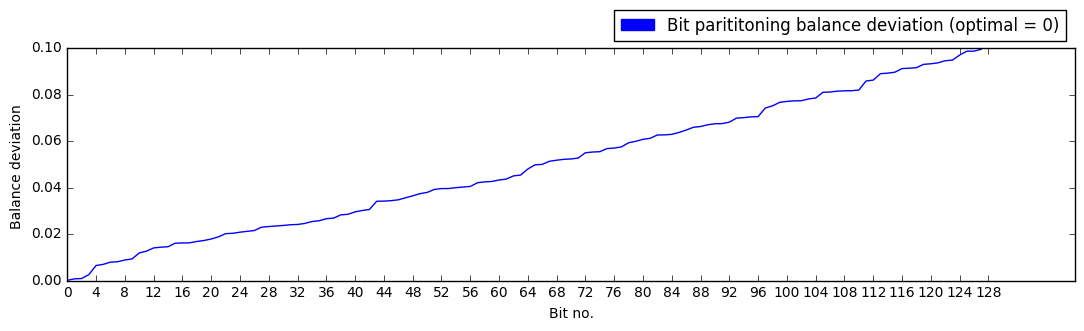

In [368]:
plt.figure(figsize=(13,3))
line=plt.plot(loaded_partitioner.balance_score, color='blue')
legend = mpatches.Patch(color='blue', label='Bit parititoning balance deviation (optimal = 0)')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Bit no.')
plt.ylabel('Balance deviation ')

plt.xticks(range(0, len(loaded_partitioner.balance_score)+1,4))
plt.show()

In [369]:
sketch_producer=SketchProducer(cfg,partitioner=loaded_partitioner)

2016-11-16 16:42:19,809 - root - INFO - SketchProducer| Transforming dataset to Sketch matrix...
2016-11-16 16:42:19,811 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100.data...
2016-11-16 16:42:20,525 - root - INFO - SketchProducer| Sketch Matrix constructed with shape (100, 128)...
2016-11-16 16:42:20,526 - root - INFO - SketchProducer| Optimizing sketch length to 16...
2016-11-16 16:42:20,527 - root - INFO - SketchProducer| Initiating bit removal...


128
128
128
128


2016-11-16 16:42:21,095 - root - INFO - SketchProducer| Removed 5 bits. Removing last 5 bits took 0.555075883865s...


128
128
128
128
128
128


2016-11-16 16:42:21,561 - root - INFO - SketchProducer| Removed 10 bits. Removing last 5 bits took 0.465804815292s...


128
128
128


2016-11-16 16:42:22,038 - root - INFO - SketchProducer| Removed 15 bits. Removing last 5 bits took 0.477167129517s...


128
128
128
128
128
128


2016-11-16 16:42:22,565 - root - INFO - SketchProducer| Removed 20 bits. Removing last 5 bits took 0.52706694603s...


128
128
128
128
128


2016-11-16 16:42:23,046 - root - INFO - SketchProducer| Removed 25 bits. Removing last 5 bits took 0.480466842651s...


128
128
128
128
128
128


2016-11-16 16:42:23,516 - root - INFO - SketchProducer| Removed 30 bits. Removing last 5 bits took 0.470340013504s...


128
128
128
128
128


2016-11-16 16:42:24,042 - root - INFO - SketchProducer| Removed 35 bits. Removing last 5 bits took 0.526265859604s...


128
128
128


2016-11-16 16:42:24,400 - root - INFO - SketchProducer| Removed 40 bits. Removing last 5 bits took 0.358022928238s...


128
128
128
128
128
128
128


2016-11-16 16:42:24,793 - root - INFO - SketchProducer| Removed 45 bits. Removing last 5 bits took 0.392980098724s...


128
128
128
128
128


2016-11-16 16:42:25,242 - root - INFO - SketchProducer| Removed 50 bits. Removing last 5 bits took 0.448627948761s...


128
128
128
128
128


2016-11-16 16:42:25,729 - root - INFO - SketchProducer| Removed 55 bits. Removing last 5 bits took 0.486931800842s...


128
128
128


2016-11-16 16:42:26,199 - root - INFO - SketchProducer| Removed 60 bits. Removing last 5 bits took 0.470128059387s...


128
128
128
128
128
128


2016-11-16 16:42:26,710 - root - INFO - SketchProducer| Removed 65 bits. Removing last 5 bits took 0.511250972748s...


128
128
128
128
128


2016-11-16 16:42:27,181 - root - INFO - SketchProducer| Removed 70 bits. Removing last 5 bits took 0.470762014389s...


128
128
128
128
128


2016-11-16 16:42:27,690 - root - INFO - SketchProducer| Removed 75 bits. Removing last 5 bits took 0.508369207382s...


128
128
128
128
128
128


2016-11-16 16:42:28,160 - root - INFO - SketchProducer| Removed 80 bits. Removing last 5 bits took 0.469976902008s...


128
128
128
128
128


2016-11-16 16:42:28,701 - root - INFO - SketchProducer| Removed 85 bits. Removing last 5 bits took 0.541542053223s...


128
128
128


2016-11-16 16:42:29,139 - root - INFO - SketchProducer| Removed 90 bits. Removing last 5 bits took 0.43759393692s...


128
128
128
128


KeyboardInterrupt: 

In [370]:
len(loaded_partitioner.pivots)

37

In [371]:
len(sketch_producer.partitioner.pivots)

128

In [373]:
mtx=np.matrix([[1,2,3],[4,5,6],[7,9,2]])
mtx

matrix([[1, 2, 3],
        [4, 5, 6],
        [7, 9, 2]])

In [401]:
mask=[False,False, True]

In [405]:
mtx.delete(mask)

AttributeError: 'matrix' object has no attribute 'delete'